In [1]:
import requests
import json

import pandas as pd
import numpy as np

import datetime
from math import floor,ceil

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#################
### FUNCTIONS ###
#################
def get_json(url,headers=[]):
    print('Getting',url,'...')
    raw = requests.get(url, headers=headers)
    raw_json = raw.json()
    return raw_json

def save_json(raw_json, fname):
    print('Saving',fname,'...')
    with open(fname, 'w') as f:
        json.dump(raw_json, f)
        
def load_json(fname):
    print('Loading',fname,'...')
    with open(fname, 'r') as f:
        raw_json = f.read()
    
    # convert to dict
    raw_json = json.loads(raw_json)
    
    return raw_json
  
def json_to_df(raw_json,prefix='',suffix='.csv'):  
    print('Converting json to data frames:')
    df_dict = {}
    for key in raw_json.keys():
        print(key+'...', end='')
        try:
            df = pd.DataFrame(raw_json[key])
            df_dict[key] = df
            df.to_csv(prefix + key + suffix, index=False)
            print('done.')
        except:
            try:
                df = pd.Series(raw_json[key])
                df_dict[key] = df
                df.to_csv(prefix + key + suffix, index=True, header=True)
                print('done.')
            except:
                print('ERROR!')
                
    return df_dict

In [3]:
##################################################################
### FIXTURE DATA (all fixtures and results for current season) ###
##################################################################   

FOOTDATA_URL = 'http://api.football-data.org/v2/competitions/2021/'
token_file = 'api.token'

SEASON_START = -1 #'2017-06-01' # Use -1 to get current season
SEASON_STOP = -1 #'2018-06-01'

if SEASON_START==-1: # current_season
    URL = FOOTDATA_URL+'matches'
else:
    URL = FOOTDATA_URL+'matches?dateFrom='+SEASON_START+'&dateTo='+SEASON_STOP

with open(token_file,'r') as f:
    token = f.read()
        
raw_json = get_json(URL,
                    headers={'X-Auth-Token':token})

save_json(raw_json, 'json/Fixtures.json')    

print('------------------')
df_dict = json_to_df(raw_json,prefix='json/Fixtures_')
print('------------------')

df = df_dict['matches']
df.head()

Getting http://api.football-data.org/v2/competitions/2021/matches ...
Saving json/Fixtures.json ...
------------------
Converting json to data frames:
count...done.
filters...done.
competition...done.
matches...done.
------------------


,awayTeam,group,homeTeam,id,lastUpdated,matchday,referees,score,season,stage,status,utcDate
0,"{'id': 338, 'name': 'Leicester City FC'}",Regular Season,"{'id': 66, 'name': 'Manchester United FC'}",233028,2019-03-03T21:34:11Z,1,"[{'id': 11610, 'name': 'Andre Marriner', 'nati...","{'winner': 'HOME_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-10T19:00:00Z
1,"{'id': 73, 'name': 'Tottenham Hotspur FC'}",Regular Season,"{'id': 67, 'name': 'Newcastle United FC'}",233026,2019-03-03T21:34:11Z,1,"[{'id': 11551, 'name': 'Martin Atkinson', 'nat...","{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T11:30:00Z
2,"{'id': 354, 'name': 'Crystal Palace FC'}",Regular Season,"{'id': 63, 'name': 'Fulham FC'}",233024,2019-03-03T21:34:11Z,1,"[{'id': 11575, 'name': 'Mike Dean', 'nationali...","{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T14:00:00Z
3,"{'id': 61, 'name': 'Chelsea FC'}",Regular Season,"{'id': 394, 'name': 'Huddersfield Town AFC'}",233029,2019-03-03T21:34:11Z,1,"[{'id': 11443, 'name': 'Chris Kavanagh', 'nati...","{'winner': 'AWAY_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T14:00:00Z
4,"{'id': 397, 'name': 'Brighton & Hove Albion FC'}",Regular Season,"{'id': 346, 'name': 'Watford FC'}",233031,2019-03-03T21:34:11Z,1,"[{'id': 11567, 'name': 'Jonathan Moss', 'natio...","{'winner': 'HOME_TEAM', 'duration': 'REGULAR',...","{'id': 151, 'startDate': '2018-08-10', 'endDat...",REGULAR_SEASON,FINISHED,2018-08-11T14:00:00Z


In [4]:
df.drop(['group','lastUpdated','referees','season','stage'],axis=1, inplace=True)
df.set_index('id',inplace=True)

In [5]:
def extract_team(team_dict):
    return team_dict['name']

df['awayTeam'] = df['awayTeam'].apply(extract_team)
df['homeTeam'] = df['homeTeam'].apply(extract_team)

df['awayTeam'] = df['awayTeam'].str.replace('AFC','')
df['awayTeam'] = df['awayTeam'].str.replace('FC','')
df['awayTeam'] = df['awayTeam'].str.strip()

df['homeTeam'] = df['homeTeam'].str.replace('AFC','')
df['homeTeam'] = df['homeTeam'].str.replace('FC','')
df['homeTeam'] = df['homeTeam'].str.strip()

In [6]:
df['winner'] = df['score'].apply(lambda x: x['winner'])
df['homeScore'] = df['score'].apply(lambda x: x['fullTime']['homeTeam'])
df['awayScore'] = df['score'].apply(lambda x: x['fullTime']['awayTeam'])

df.drop('score',axis=1,inplace=True)

In [7]:
def homepts_from_winner(winner):
    if winner=='HOME_TEAM':
        return 3
    elif winner=='DRAW':
        return 1
    elif winner=='AWAY_TEAM':
        return 0
    else:
        return np.nan
    
df['homePts'] = df['winner'].apply(homepts_from_winner)

def awaypts_from_winner(winner):
    if winner=='AWAY_TEAM':
        return 3
    elif winner=='DRAW':
        return 1
    elif winner=='HOME_TEAM':
        return 0
    else:
        return np.nan
    
df['awayPts'] = df['winner'].apply(awaypts_from_winner)

In [8]:
df['homeGD'] = df['homeScore']-df['awayScore']
df['awayGD'] = df['awayScore']-df['homeScore']

In [9]:
df['utcDate'] = pd.to_datetime(df['utcDate'])

In [10]:
df.head()

,awayTeam,homeTeam,matchday,status,utcDate,winner,homeScore,awayScore,homePts,awayPts,homeGD,awayGD
id,,,,,,,,,,,,
233028,Leicester City,Manchester United,1,FINISHED,2018-08-10 19:00:00+00:00,HOME_TEAM,2.0,1.0,3.0,0.0,1.0,-1.0
233026,Tottenham Hotspur,Newcastle United,1,FINISHED,2018-08-11 11:30:00+00:00,AWAY_TEAM,1.0,2.0,0.0,3.0,-1.0,1.0
233024,Crystal Palace,Fulham,1,FINISHED,2018-08-11 14:00:00+00:00,AWAY_TEAM,0.0,2.0,0.0,3.0,-2.0,2.0
233029,Chelsea,Huddersfield Town,1,FINISHED,2018-08-11 14:00:00+00:00,AWAY_TEAM,0.0,3.0,0.0,3.0,-3.0,3.0
233031,Brighton & Hove Albion,Watford,1,FINISHED,2018-08-11 14:00:00+00:00,HOME_TEAM,2.0,0.0,3.0,0.0,2.0,-2.0


In [11]:
def select_team_fixtures(team):
    return df[(df['homeTeam']==team) | (df['awayTeam']==team)]

select_team_fixtures('Manchester United')

,awayTeam,homeTeam,matchday,status,utcDate,winner,homeScore,awayScore,homePts,awayPts,homeGD,awayGD
id,,,,,,,,,,,,
233028,Leicester City,Manchester United,1,FINISHED,2018-08-10 19:00:00+00:00,HOME_TEAM,2.0,1.0,3.0,0.0,1.0,-1.0
233042,Manchester United,Brighton & Hove Albion,2,FINISHED,2018-08-19 15:00:00+00:00,HOME_TEAM,3.0,2.0,3.0,0.0,1.0,-1.0
233048,Tottenham Hotspur,Manchester United,3,FINISHED,2018-08-27 19:00:00+00:00,AWAY_TEAM,0.0,3.0,0.0,3.0,-3.0,3.0
233057,Manchester United,Burnley,4,FINISHED,2018-09-02 15:00:00+00:00,AWAY_TEAM,0.0,2.0,0.0,3.0,-2.0,2.0
233071,Manchester United,Watford,5,FINISHED,2018-09-15 16:30:00+00:00,AWAY_TEAM,1.0,2.0,0.0,3.0,-1.0,1.0
233076,Wolverhampton Wanderers,Manchester United,6,FINISHED,2018-09-22 14:00:00+00:00,DRAW,1.0,1.0,1.0,1.0,0.0,0.0
233091,Manchester United,West Ham United,7,FINISHED,2018-09-29 11:30:00+00:00,HOME_TEAM,3.0,1.0,3.0,0.0,2.0,-2.0
233096,Newcastle United,Manchester United,8,FINISHED,2018-10-06 16:30:00+00:00,HOME_TEAM,3.0,2.0,3.0,0.0,1.0,-1.0
233107,Manchester United,Chelsea,9,FINISHED,2018-10-20 11:30:00+00:00,DRAW,2.0,2.0,1.0,1.0,0.0,0.0


In [12]:
teams = sorted(df['homeTeam'].unique())

table = pd.DataFrame(index=teams,columns=['pld','gd','pts'])

for team in teams:
    pts = df.loc[df['homeTeam']==team, 'homePts'].sum() + df.loc[df['awayTeam']==team, 'awayPts'].sum()
    gd = df.loc[df['homeTeam']==team, 'homeGD'].sum() + df.loc[df['awayTeam']==team, 'awayGD'].sum()
    pld = sum((df['homeTeam']==team) & (df['status']=='FINISHED')) + sum((df['awayTeam']==team) & (df['status']=='FINISHED'))
    
    table.loc[team,'pts'] = pts
    table.loc[team,'gd'] = gd
    table.loc[team,'pld'] = pld
    
table.sort_values(by='pts',ascending=False)

,pld,gd,pts
Manchester City,29,56,71
Liverpool,29,49,70
Tottenham Hotspur,29,26,61
Manchester United,29,20,58
Arsenal,29,22,57
Chelsea,28,19,56
Watford,29,0,43
Wolverhampton Wanderers,29,2,43
West Ham United,29,-4,39
Everton,29,0,37


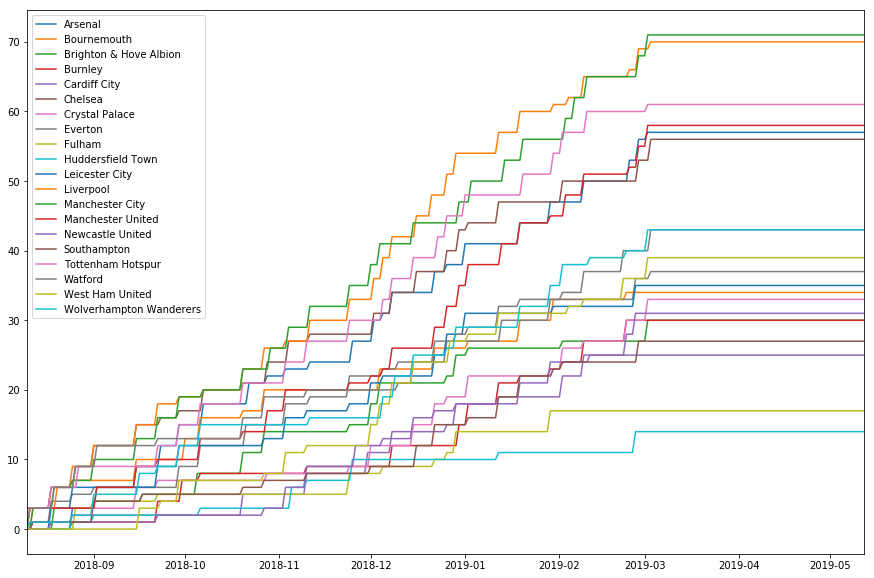

In [13]:
dates = pd.date_range(start=df['utcDate'].min(),end=df['utcDate'].max(),normalize=True)
dates = dates.date

date_pts = pd.DataFrame(index=dates,columns=teams)

for date in dates:
    fixtures_to_date = df[df['utcDate'].dt.date < date+datetime.timedelta(days=1)]
    
    for team in teams:
        pts = fixtures_to_date.loc[fixtures_to_date['homeTeam']==team, 'homePts'].sum() 
        pts = pts + fixtures_to_date.loc[fixtures_to_date['awayTeam']==team, 'awayPts'].sum()
        
        date_pts.loc[date,team] = pts
        
ax = plt.figure(figsize=(15,10)).gca()
date_pts.plot(ax=ax)

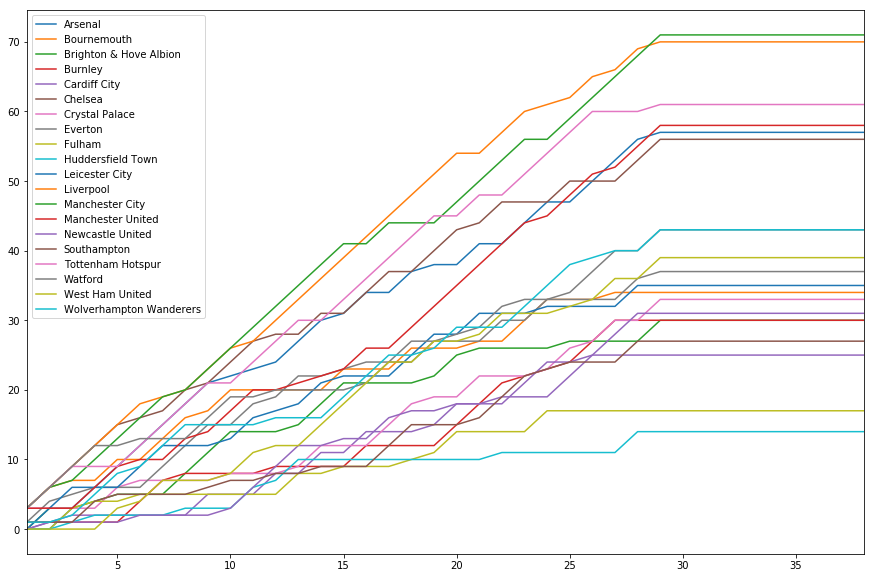

In [14]:
matchdays = sorted(df['matchday'].unique())

matchday_pts = pd.DataFrame(index=matchdays,columns=teams)
matchday_gd = pd.DataFrame(index=matchdays,columns=teams)

for matchday in matchdays:
    fixtures_to_date = df[df['matchday'] <= matchday]
    
    for team in teams:
        pts = fixtures_to_date.loc[fixtures_to_date['homeTeam']==team, 'homePts'].sum() 
        pts = pts + fixtures_to_date.loc[fixtures_to_date['awayTeam']==team, 'awayPts'].sum()
        matchday_pts.loc[matchday,team] = pts

        gd = fixtures_to_date.loc[fixtures_to_date['homeTeam']==team, 'homeGD'].sum()
        gd = gd + fixtures_to_date.loc[fixtures_to_date['awayTeam']==team, 'awayGD'].sum()        
        matchday_gd.loc[matchday,team] = gd
        
ax = plt.figure(figsize=(15,10)).gca()
matchday_pts.plot(ax=ax)

matchday_pts.loc[0] = [0]*20
matchday_pts.sort_index(inplace=True)

matchday_gd.loc[0] = [0]*20
matchday_gd.sort_index(inplace=True)

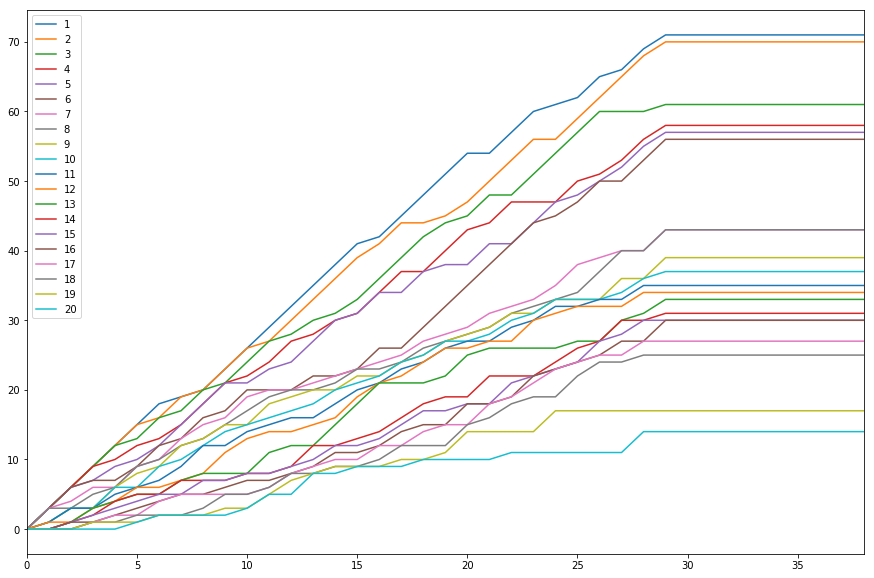

In [15]:
matchday_rankpts = pd.DataFrame(index=matchdays,columns=range(1,21))

for matchday in matchdays:
    pts = matchday_pts.loc[matchday]
    sorted_pts = pts.sort_values(ascending=False)
    matchday_rankpts.loc[matchday,:] = sorted_pts.values

matchday_rankpts.loc[0] = [0]*20
matchday_rankpts.sort_index(inplace=True)

ax = plt.figure(figsize=(15,10)).gca()
matchday_rankpts.plot(ax=ax)

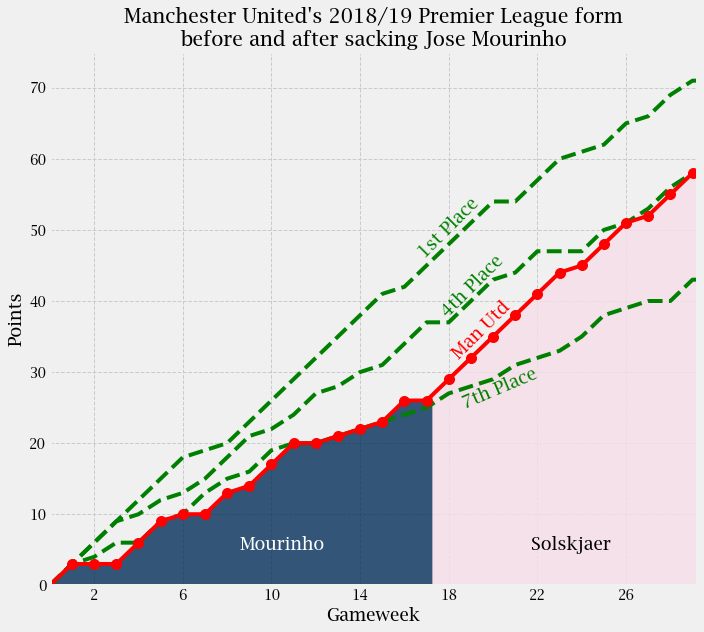

In [25]:
import matplotlib as mpl
mpl.rc('font',family='Lucida Bright')

with plt.style.context('fivethirtyeight'):
    
    ax = plt.figure(figsize=(10,9)).gca()

    plt.plot(matchday_rankpts[1],'g--',label='1st Place')#,linewidth=1,color='#F4FFBF')
    #plt.plot(matchday_rankpts[2],label='2nd Place')#,linewidth=1,color='#80FF80')
    #plt.plot(matchday_rankpts[3],label='3rd Place')#,linewidth=1,color='#40FF91')
    plt.plot(matchday_rankpts[4],'g--',label='4th Place')#,linewidth=1,color='#00FFFF')
    #plt.plot(matchday_rankpts[5],label='5th Place')#,linewidth=1,color='#0052BF')
    #plt.plot(matchday_rankpts[6],label='6th Place')#,linewidth=1,color='#000080')
    plt.plot(matchday_rankpts[7],'g--',label='7th Place')#,linewidth=1,color='#350040')

    plt.plot(matchday_pts['Manchester United'],'ro-',label='Man Utd',linewidth=4,markersize=10)

    #plt.legend()

    #plt.plot([17.25,17.25],[-1,75],'k',linewidth=4)

    #plt.legend(fontsize=12)
    plt.xlabel('Gameweek',fontsize=18)
    plt.ylabel('Points',fontsize=18)
    plt.xticks(range(2,30,4),fontsize=14)
    plt.yticks(fontsize=14)

    plt.text(10.5,5,'Mourinho',horizontalalignment='center',fontsize=18,color='white')
    plt.text(23.5,5,'Solskjaer',horizontalalignment='center',fontsize=18)

    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)
    #ax.xaxis.set_ticks_position('bottom')
    #ax.yaxis.set_ticks_position('left')

    def manutd_pts(matchday):  
        try:
            return [manutd_pts(md) for md in matchday]

        except TypeError:
            if matchday==0:
                return 0

            elif round(matchday)==matchday:
                return matchday_pts.loc[matchday,'Manchester United']

            else:
                # linear fit to get non-integer values
                md_start = floor(matchday)
                md_end = ceil(matchday)

                pts_start = manutd_pts(md_start)
                pts_end = manutd_pts(md_end)

                gradient = (pts_end-pts_start)/(md_end-md_start)

                return (matchday-md_start)*gradient + pts_start

    section = np.arange(0, 17.5, 0.25)
    plt.fill_between(section,manutd_pts(section),color='#032E5A',alpha=0.8)
    section = np.arange(17.25, 30, 0.25)
    plt.fill_between(section,manutd_pts(section),color='#F7DEE8',alpha=0.8)

    plt.xlim([0,29.2])
    plt.ylim([0,75])
    
    ax.grid(linestyle='--')
    
    plt.text(16.5,53,'1st Place',rotation=45,color='g',fontsize=18)
    plt.text(17.5,45,'4th Place',rotation=45,color='g',fontsize=18)
    plt.text(18.5,29,'7th Place',rotation=23,color='g',fontsize=18)
    plt.text(18,38.5,'Man Utd',rotation=45,color='r',fontsize=18)
    
    plt.title("Manchester United's 2018/19 Premier League form\nbefore and after sacking Jose Mourinho")
    plt.tight_layout()
    plt.savefig('pts_vs_gameweek.png',dpi=300)

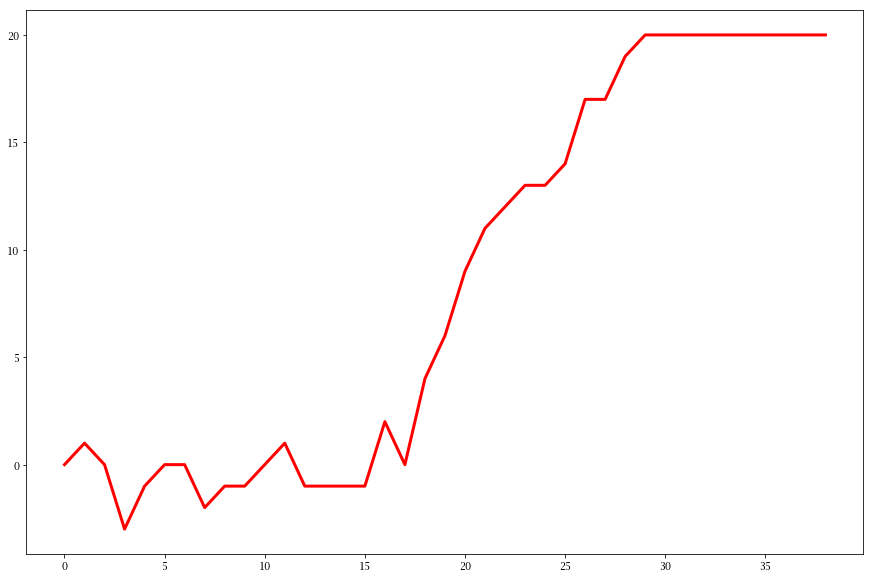

In [17]:
ax = plt.figure(figsize=(15,10)).gca()
plt.plot(matchday_gd['Manchester United'],'r',linewidth=3)

Text(19,5,'Solskjaer')

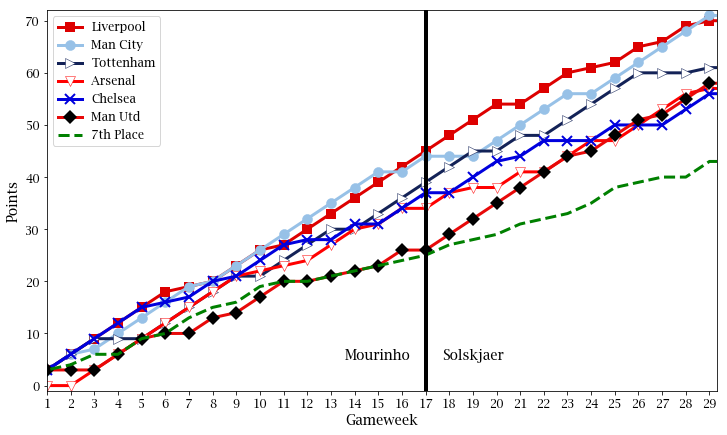

In [18]:
ax = plt.figure(figsize=(12,7)).gca()

plt.plot(matchday_pts.index, matchday_pts['Liverpool'],'s-',label='Liverpool',
         color='#dd0000',markerfacecolor='#dd0000',markeredgewidth=0,linewidth=3,markersize=10)

plt.plot(matchday_pts['Manchester City'],'o-', label='Man City',
         color='#97c1e7',markerfacecolor='#97c1e7',markeredgewidth=0.5,linewidth=3,markersize=10)

plt.plot(matchday_pts['Tottenham Hotspur'],'>-', label='Tottenham',
         color='#132257',markerfacecolor='#ffffff',markeredgewidth=0.5,linewidth=3,markersize=10)

plt.plot(matchday_pts['Arsenal'],'v-', label='Arsenal',
         color='#ff0000',markerfacecolor='#ffffff',markeredgewidth=0.5,linewidth=3,markersize=10)

plt.plot(matchday_pts['Chelsea'],'x-', label='Chelsea',
         color='#0000dd',markerfacecolor='#0000dd',linewidth=3,markersize=10,markeredgewidth=2)

plt.plot(matchday_pts['Manchester United'],'D-', label='Man Utd',
         color='#e80909',markerfacecolor='#000000',markeredgewidth=0,linewidth=3,markersize=10)

plt.plot(matchday_rankpts[7],'g--',linewidth=3, label='7th Place')


plt.plot([17,17],[-1,75],'k',linewidth=4)

plt.xlim([1,29.3])
plt.ylim([-1,72])

plt.legend(fontsize=12)
plt.xlabel('Gameweek',fontsize=14)
plt.ylabel('Points',fontsize=14)
plt.xticks(range(1,30),fontsize=12)
plt.yticks(fontsize=12)

plt.text(15,5,'Mourinho',horizontalalignment='center',fontsize=14)
plt.text(19,5,'Solskjaer',horizontalalignment='center',fontsize=14)

In [19]:
'''
import matplotlib as mpl
mpl.rc('font',family='Lucida Bright')

with plt.style.context('fivethirtyeight'):
    
    ax = plt.figure(figsize=(10,9)).gca()

    plt.plot(matchday_rankpts[1],'k--',label='1st Place',linewidth=1.5)
    plt.plot(matchday_rankpts[3],'k--',label='3rd Place',linewidth=1.5)

    plt.plot(matchday_pts['Manchester United'],'ro-',label='Man Utd',linewidth=4,markersize=10)

    plt.xlabel('Gameweek',fontsize=18)
    plt.ylabel('Points',fontsize=18)
    plt.xticks(range(2,40,4),fontsize=14)
    plt.yticks(fontsize=14)
    
    ax.grid(linestyle='--')
    
    plt.text(14,53,'1st Place',rotation=45,color='k',fontsize=18)
    plt.text(18,41,'3rd Place',rotation=45,color='k',fontsize=18)
    plt.text(16,48,'Man Utd',rotation=45,color='r',fontsize=18)
    
    plt.title('Man Utd: 2017/18 Season')
    
    plt.tight_layout()
    plt.savefig('pts_vs_gameweek_1718.png',dpi=300)
'''

"\nimport matplotlib as mpl\nmpl.rc('font',family='Lucida Bright')\n\nwith plt.style.context('fivethirtyeight'):\n    \n    ax = plt.figure(figsize=(10,9)).gca()\n\n    plt.plot(matchday_rankpts[1],'k--',label='1st Place',linewidth=1.5)\n    plt.plot(matchday_rankpts[3],'k--',label='3rd Place',linewidth=1.5)\n\n    plt.plot(matchday_pts['Manchester United'],'ro-',label='Man Utd',linewidth=4,markersize=10)\n\n    plt.xlabel('Gameweek',fontsize=18)\n    plt.ylabel('Points',fontsize=18)\n    plt.xticks(range(2,40,4),fontsize=14)\n    plt.yticks(fontsize=14)\n    \n    ax.grid(linestyle='--')\n    \n    plt.text(14,53,'1st Place',rotation=45,color='k',fontsize=18)\n    plt.text(18,41,'3rd Place',rotation=45,color='k',fontsize=18)\n    plt.text(16,48,'Man Utd',rotation=45,color='r',fontsize=18)\n    \n    plt.title('Man Utd: 2017/18 Season')\n    \n    plt.tight_layout()\n    plt.savefig('pts_vs_gameweek_1718.png',dpi=300)\n"